In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import xarray as xr # for handling climate data
from pandarallel import pandarallel # for running pandas functions in parallel
import multiprocessing # for general parallelizing of codes
import tqdm # for having progres bar
from functools import partial # for full control over handling function arguemnts
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)
import pandas as pd
from datetime import datetime, date
import matplotlib
from netCDF4 import Dataset
import xarray as xr

INFO: Pandarallel will run on 23 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
ds = xr.open_dataset('./InputData/coarse_tmmx.nc')

In [3]:
monthly_data = ds.resample(day='1M').mean()
month_length = monthly_data.day.dt.days_in_month

In [4]:
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('day.season') / month_length.groupby('day.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('day.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (monthly_data * weights).groupby('day.season').sum(dim='day')

In [5]:
lat = ds_weighted.variables['lat'][:]
lon = ds_weighted.variables['lon'][:]
lons, lats = np.meshgrid(lon, lat)
temp = ds_weighted.sel(season="DJF").variables['air_temperature']
temp

<xarray.Variable (lat: 59, lon: 139)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [280.57084526, 280.45203279, 280.5339307 , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

<ipython-input-6-28e463c5c485>:22: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, temp-273.15, cmap='RdBu_r',
<ipython-input-6-28e463c5c485>:22: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, temp-273.15, cmap='RdBu_r',
<ipython-input-6-28e463c5c485>:22: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, temp-273.15, cmap='RdBu_r',
<ipython-input-6-28

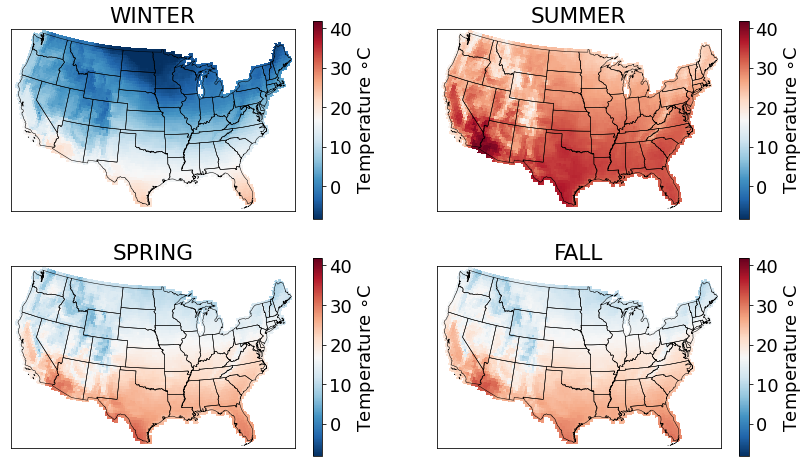

In [6]:
# Quick plot to show the results
matplotlib.rcParams.update({'font.size': 18})
my_seasons = {
    "DJF": "WINTER",
    "MAM": "SPRING",
    "JJA": "SUMMER",
    "SON": "FALL"
}
notnull = pd.notnull(ds_weighted['air_temperature'][0])
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    axis = axs[i%2, i//2] 
    temp = ds_weighted.sel(season=season).variables['air_temperature']
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=32,lat_2=49,lon_0=-95, ax = axis)
    x, y = m(lons, lats)
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            if temp[i, j] == 0:
                temp[i, j] = np.nan
    m1 = m.pcolor(x, y, temp-273.15, cmap='RdBu_r',
                  shading="nearest", ax =axis,
                  vmin = 265-273.15, vmax = 315-273.15)
    fig.colorbar(m1, ax=axis, orientation="vertical",
                    label='Temperature $\circ$C')
    hp_info = m.readshapefile('./InputData/st99_d00','states',drawbounds=True)
    statenames=[]
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        statenames.append(statename)
    for nshape,seg in enumerate(m.states):
        if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
            poly = Polygon(seg,facecolor=None,edgecolor='black', alpha=0)
            axis.add_patch(poly)
    axis.set_title(my_seasons[season])
#fig.suptitle('Tem')

fig.savefig("season_temp_new.png",dpi = 360 )


In [7]:
ds2 = xr.open_dataset('./InputData/coarse_pr.nc')

In [8]:
monthly_data2 = ds2.resample(day='1M').mean()
month_length2 = monthly_data2.day.dt.days_in_month

In [9]:
# Calculate the weights by grouping by 'time.season'.
weights2 = month_length2.groupby('day.season') / month_length2.groupby('day.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights2.groupby('day.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted2 = (monthly_data2 * weights2).groupby('day.season').sum(dim='day')

In [10]:
temp = ds_weighted2.sel(season="DJF").variables['precipitation_amount']
lat = ds_weighted2.variables['lat'][:]
lon = ds_weighted2.variables['lon'][:]
lons, lats = np.meshgrid(lon, lat)

<ipython-input-11-e7e319d5d8df>:23: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, pr-0.01, cmap='viridis_r',
<ipython-input-11-e7e319d5d8df>:23: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, pr-0.01, cmap='viridis_r',
<ipython-input-11-e7e319d5d8df>:23: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  m1 = m.pcolor(x, y, pr-0.01, cmap='viridis_r',
<ipython-input-11-e

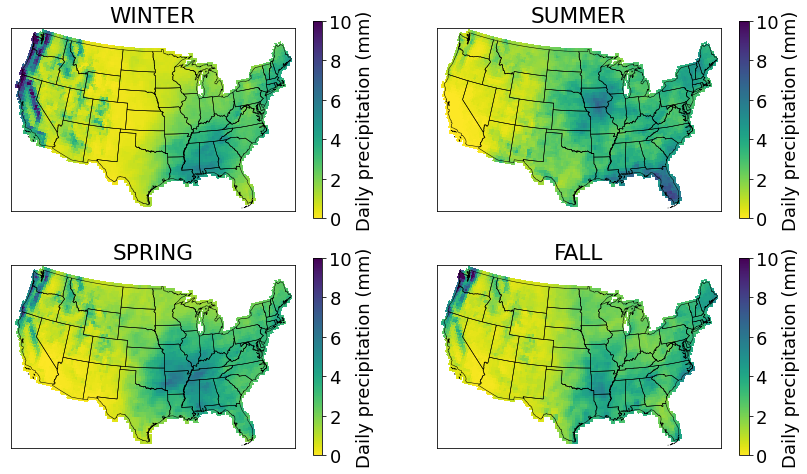

In [11]:
# Quick plot to show the results
matplotlib.rcParams.update({'font.size': 18})
my_seasons = {
    "DJF": "WINTER",
    "MAM": "SPRING",
    "JJA": "SUMMER",
    "SON": "FALL"
}
notnull = pd.notnull(ds_weighted2['precipitation_amount'][0])
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    axis = axs[i%2, i//2] 
    pr = ds_weighted2.sel(season=season).variables['precipitation_amount']
    pr= pr.values
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=32,lat_2=49,lon_0=-95, ax = axis)
    x, y = m(lons, lats)
    for i in range(pr.shape[0]):
        for j in range(pr.shape[1]):
            if pr[i, j] == 0:
                pr[i, j] = np.nan
    m1 = m.pcolor(x, y, pr-0.01, cmap='viridis_r',
                  shading="nearest", ax =axis, vmin=0.0, vmax = 10.0)
    fig.colorbar(m1, ax=axis, orientation="vertical",
                    label='Daily precipitation (mm)')
    hp_info = m.readshapefile('./InputData/st99_d00','states',drawbounds=True)
    statenames=[]
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        statenames.append(statename)
    for nshape,seg in enumerate(m.states):
        if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
            poly = Polygon(seg,facecolor=None,edgecolor='black', alpha=0)
            axis.add_patch(poly)
    axis.set_title(my_seasons[season])
#fig.suptitle('Tem')

fig.savefig("season_pr_new.png",dpi = 360 )
